In [1]:
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from utils import ugv_utils as ugvu
from visualization import papermode

papermode(plt, size=18)

In [2]:
abbrs = u.abbrange("M", 1, 8)
for abbr in abbrs:
    print(abbr, u.get_filename(abbr))

M01 M01_2022-09-14-19-01-10-AP-LinParking01_elec
M02 M02_2022-09-14-19-05-20-AP-LinParking02_elec
M03 M03_2022-09-14-19-09-59-AP-RotParkingCCW01_elec
M04 M04_2022-09-14-19-13-56-AP-RotParkingCW02_elec
M05 M05_2022-09-12-15-14-00-GD-RotDumpCCW01_elec
M06 M06_2022-09-12-15-16-51-GD-RotDumpCCW02_elec
M07 M07_2022-09-12-15-08-14-GD-LinDump_elec


In [3]:
# abbrs = {
#     "asphalt": {
#         "lin": ("M01", "M02"),
#         "rot": ("M03", "M04"),
#     },
#     "gravel": {
#         "lin": ("M07",),
#         "rot": ("M05", "M06"),
#     },
# }
abbrs = {
    "asphalt": {
        "lin": ("M01", "M02"),
        "rot": ("M03", "M06", "M04", "M05"),
    },
    "gravel": {
        "lin": ("M07",),
        "rot": ("M05", "M06"),
    },
}
all_abbrs = tuple(tuple(a.values()) for a in abbrs.values())
all_abbrs = tuple(itertools.chain.from_iterable(all_abbrs))
all_abbrs = tuple(itertools.chain.from_iterable(all_abbrs))

invert_dict = lambda d: {v1: k for k, v in d.items() for v1 in v}
linrot = {terr: invert_dict(a) for terr, a in abbrs.items()}

print(all_abbrs)
for abbr in all_abbrs:
    preprocess(abbr, verbose=False)


('M01', 'M02', 'M03', 'M06', 'M04', 'M05', 'M07', 'M05', 'M06')


In [4]:
# All model dfs
mdfs = {}
# All spans numbers
spans = {t: {} for t in abbrs.keys()}

for terrain in abbrs.keys():
    terr_abbrs = (*abbrs[terrain]["lin"], *abbrs[terrain]["rot"])
    terr_dfs = tuple(ugvu.read_df_rename_columns(ab) for ab in terr_abbrs)
    terr_linrot = linrot[terrain]

    big_df = ugvu.append_dfs(terr_dfs)

    m2009_df = big_df.copy()
    m2009_df.meta = big_df.meta
    p2014_df = big_df.copy()
    p2014_df.meta = big_df.meta
    p2022_df = big_df.copy()
    p2022_df.meta = big_df.meta
    m2009_df = morales2009.morales2009(
        abbr=m2009_df.meta.abbr,
        df=m2009_df,
        verbose=False,
        compute_errors=False,
    )
    p2014_df = pentzer2014pow.pentzer2014pow(
        abbr=p2014_df.meta.abbr,
        df=p2014_df,
        verbose=False,
        compute_errors=False,
    )
    p2022_df = pentzer2022.pentzer2022(
        abbr=p2022_df.meta.abbr,
        df=p2022_df,
        verbose=False,
        compute_errors=False,
        detect_terrains=False,
    )

    mdfs[terrain] = {
        "m2009": m2009_df,
        "p2014": p2014_df,
        "p2022": p2022_df,
    }

    for abbr in terr_abbrs:
        span = m2009_df[m2009_df.abbr == abbr].copy()
        spans[terrain].setdefault("st", []).append(span.time_rel.head(1).item())
        spans[terrain].setdefault("en", []).append(span.time_rel.tail(1).item())
    sts, ens = spans[terrain]["st"][1:], spans[terrain]["en"][:-1]
    spans[terrain]["div"] = [(s + e) / 2 for s, e in zip(sts, ens)]

M07M05M06: 100%|██████████| 398/398 [00:00<00:00, 6607.19it/s]


# Downhill

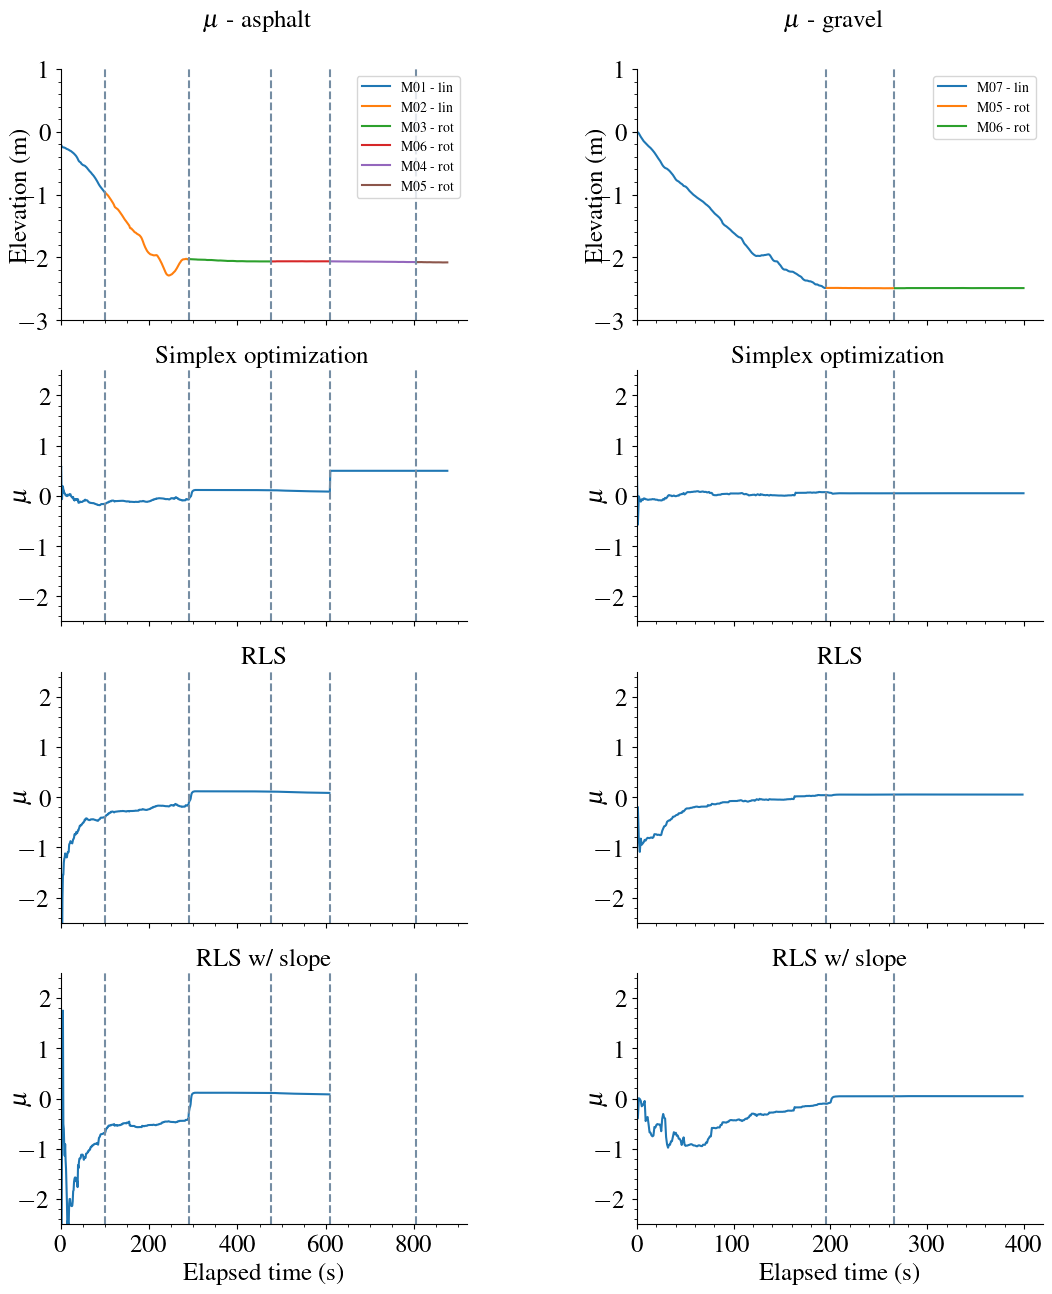

In [5]:
fig = plt.figure(figsize=(11, 15))
subfigs = fig.subfigures(ncols=2, wspace=0.1)

for subfig, terrain in zip(subfigs, abbrs.keys()):
    axs = subfig.subplots(nrows=4, sharex=True)

    terr_abbrs = (*abbrs[terrain]["lin"], *abbrs[terrain]["rot"])
    terr_linrot = linrot[terrain]
    m2009_df = mdfs[terrain]["m2009"]
    p2014_df = mdfs[terrain]["p2014"]
    p2022_df = mdfs[terrain]["p2022"]

    for abbr in terr_abbrs:
        abbr_mask = m2009_df.abbr == abbr
        abbrlab = label = f"{abbr} - {terr_linrot[abbr]}"
        axs[0].plot(m2009_df[abbr_mask].time_rel, m2009_df[abbr_mask].pz, label=abbrlab)
    # axs[0].plot(m2009_df.time_rel, m2009_df.pz, label=f"{abbr} - {terr_linrot[abbr]}")
    axs[0].set_ylabel("Elevation (m)")
    axs[0].yaxis.set_label_coords(-0.07, 0.5)
    axs[0].set_ylim(bottom=-3, top=1)
    axs[0].legend(fontsize=10)

    axs[1].plot(m2009_df.time_rel, m2009_df.m_sym)
    axs[1].set_ylabel("$\mu$")
    axs[1].yaxis.set_label_coords(-0.07, 0.5)
    axs[1].set_ylim(bottom=-2.5, top=2.5)
    axs[1].set_title("Simplex optimization")

    axs[2].plot(p2014_df.time_rel, p2014_df.m_sym)
    axs[2].set_ylabel("$\mu$")
    axs[2].yaxis.set_label_coords(-0.07, 0.5)
    axs[2].set_ylim(bottom=-2.5, top=2.5)
    axs[2].set_title("RLS")

    axs[3].plot(p2022_df.time_rel, p2022_df.m_sym)
    axs[3].set_ylabel("$\mu$")
    axs[3].yaxis.set_label_coords(-0.07, 0.5)
    axs[3].set_ylim(bottom=-2.5, top=2.5)
    axs[3].set_title("RLS w/ slope")

    axs[3].set_xlabel("Elapsed time (s)")
    axs[3].xaxis.set_label_coords(0.5, -0.15)
    axs[3].set_xlim(left=0)

    for ax in axs:
        ax.spines[["right", "top"]].set_visible(False)
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        for div in spans[terrain]["div"]:
            ax.axvline(x=div, color="xkcd:blue/grey", linestyle="--")

    subfig.suptitle(f"$\mu$ - {terrain}", y=0.92)

# subfigs[0].set_facecolor("coral")
# subfigs[1].set_facecolor("xkcd:blue/grey")


# for ext in u.EXTS:
#     fig.savefig(figdir / f"warthog-hill.{ext}", bbox_inches="tight")

In [6]:
for terrain in abbrs.keys():
    m2009_df = mdfs[terrain]["m2009"]

    mdfs[terrain]["m2009"]["Pest"] = m2009_df.m_sym * m2009_df.JS_sym + m2009_df.G_sym * m2009_df.JG
    mdfs[terrain]["m2009"]["Perr"] = m2009_df.P_motion - m2009_df.Pest

    p2014_df = mdfs[terrain]["p2014"]
    mdfs[terrain]["p2014"]["Pest"] = p2014_df.m_sym * p2014_df.JS_sym + p2014_df.G_sym * p2014_df.JG
    mdfs[terrain]["p2014"]["Perr"] = p2014_df.P_motion - p2014_df.Pest

    p2022_df = mdfs[terrain]["p2022"]
    mdfs[terrain]["p2022"]["Pest"] = p2022_df.m_sym * p2022_df.JS_sym + p2022_df.G_sym * p2022_df.JG
    mdfs[terrain]["p2022"]["Perr"] = p2022_df.P_motion - p2022_df.Pest

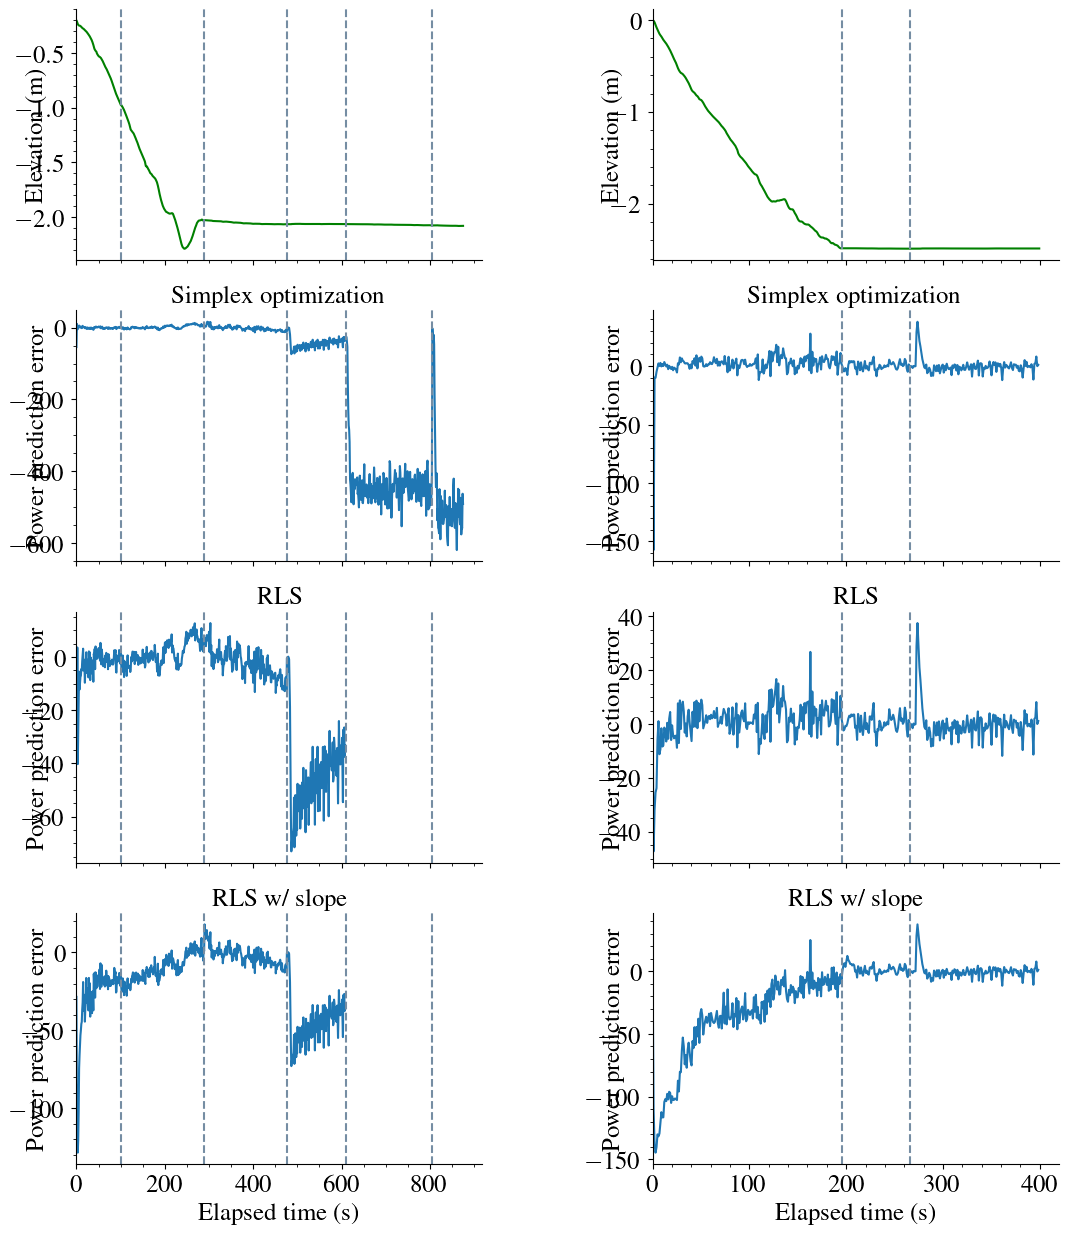

In [7]:
fig = plt.figure(figsize=(11, 15))
subfigs = fig.subfigures(ncols=2, wspace=0.1)

for subfig, terrain in zip(subfigs, abbrs.keys()):
    axs = subfig.subplots(nrows=4, sharex=True)

    m2009_df = mdfs[terrain]["m2009"]
    p2014_df = mdfs[terrain]["p2014"]
    p2022_df = mdfs[terrain]["p2022"]

    axs[0].plot(m2009_df.time_rel, m2009_df.pz, "g")
    axs[0].set_ylabel("Elevation (m)")
    axs[0].yaxis.set_label_coords(-0.07, 0.5)

    axs[1].plot(m2009_df.time_rel, m2009_df.Perr)
    axs[1].set_ylabel("Power prediction error")
    axs[1].yaxis.set_label_coords(-0.07, 0.5)
    # axs[1].set_ylim(bottom=-2.5, top=2.5)
    axs[1].set_title("Simplex optimization")

    axs[2].plot(p2014_df.time_rel, p2014_df.Perr)
    axs[2].set_ylabel("Power prediction error")
    axs[2].yaxis.set_label_coords(-0.07, 0.5)
    # axs[2].set_ylim(bottom=-2.5, top=2.5)
    axs[2].set_title("RLS")

    axs[3].plot(p2022_df.time_rel, p2022_df.Perr)
    axs[3].set_ylabel("Power prediction error")
    axs[3].yaxis.set_label_coords(-0.07, 0.5)
    # axs[3].set_ylim(bottom=-2.5, top=2.5)
    axs[3].set_title("RLS w/ slope")

    axs[3].set_xlabel("Elapsed time (s)")
    axs[3].xaxis.set_label_coords(0.5, -0.15)
    axs[3].set_xlim(left=0)

    for ax in axs:
        ax.spines[["right", "top"]].set_visible(False)
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        for div in spans[terrain]["div"]:
            ax.axvline(x=div, color="xkcd:blue/grey", linestyle="--")


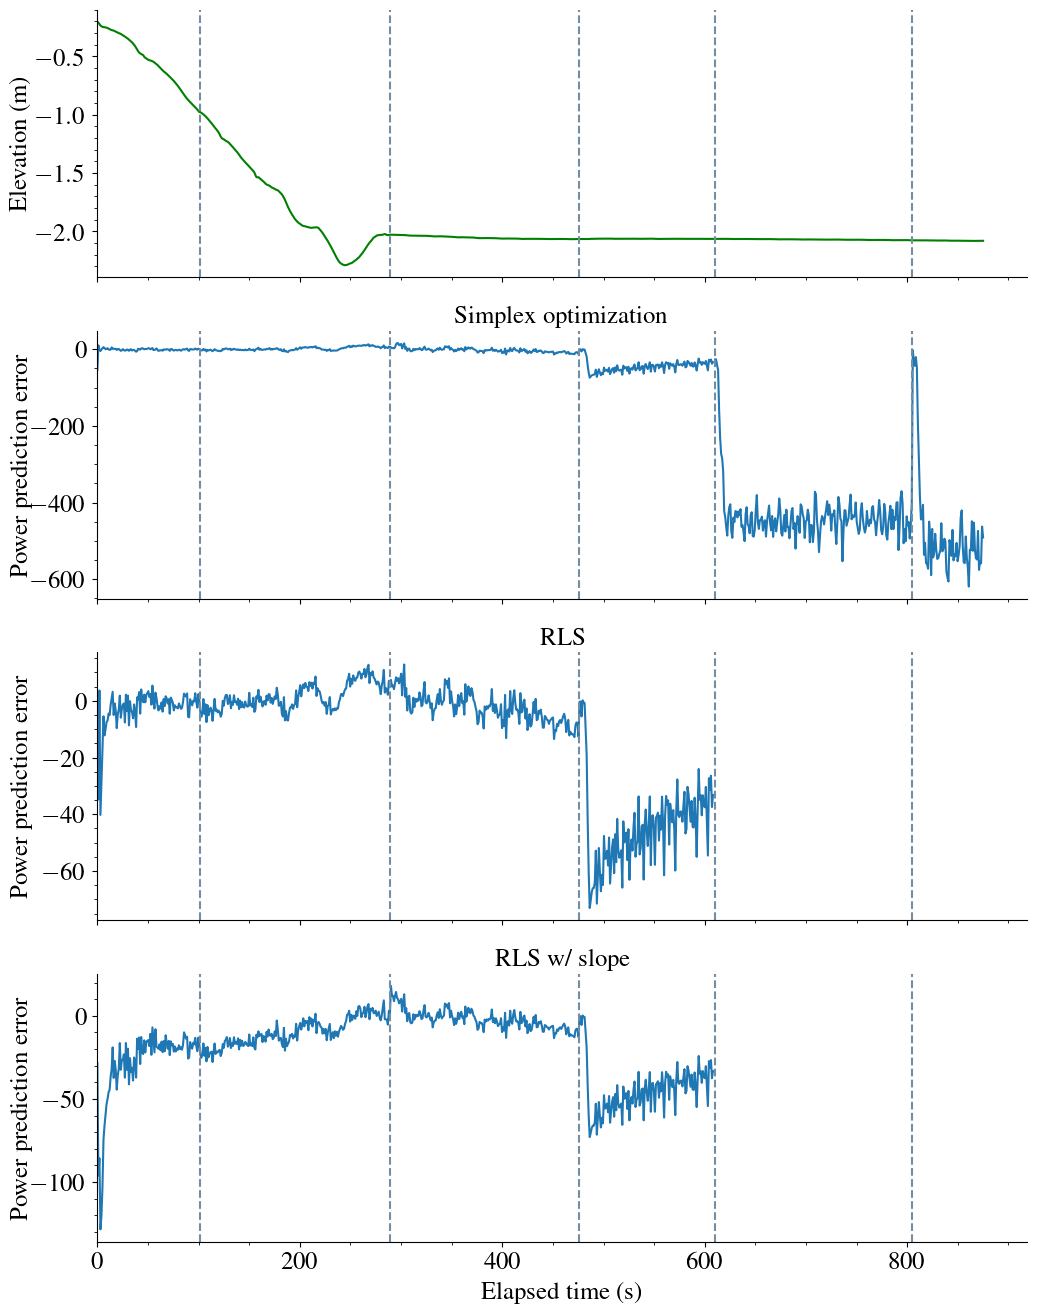

In [8]:
fig, axs = plt.subplots(figsize=(12, 16), nrows=4, sharex=True)

terrain = "asphalt"

m2009_df = mdfs[terrain]["m2009"]
p2014_df = mdfs[terrain]["p2014"]
p2022_df = mdfs[terrain]["p2022"]

axs[0].plot(m2009_df.time_rel, m2009_df.pz, "g")
axs[0].set_ylabel("Elevation (m)")
axs[0].yaxis.set_label_coords(-0.07, 0.5)

axs[1].plot(m2009_df.time_rel, m2009_df.Perr)
axs[1].set_ylabel("Power prediction error")
axs[1].yaxis.set_label_coords(-0.07, 0.5)
# axs[1].set_ylim(bottom=-2.5, top=2.5)
axs[1].set_title("Simplex optimization")

axs[2].plot(p2014_df.time_rel, p2014_df.Perr)
axs[2].set_ylabel("Power prediction error")
axs[2].yaxis.set_label_coords(-0.07, 0.5)
# axs[2].set_ylim(bottom=-2.5, top=2.5)
axs[2].set_title("RLS")

axs[3].plot(p2022_df.time_rel, p2022_df.Perr)
axs[3].set_ylabel("Power prediction error")
axs[3].yaxis.set_label_coords(-0.07, 0.5)
# axs[3].set_ylim(bottom=-2.5, top=2.5)
axs[3].set_title("RLS w/ slope")

axs[3].set_xlabel("Elapsed time (s)")
axs[3].xaxis.set_label_coords(0.5, -0.15)
axs[3].set_xlim(left=0)

for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    for div in spans[terrain]["div"]:
        ax.axvline(x=div, color="xkcd:blue/grey", linestyle="--")

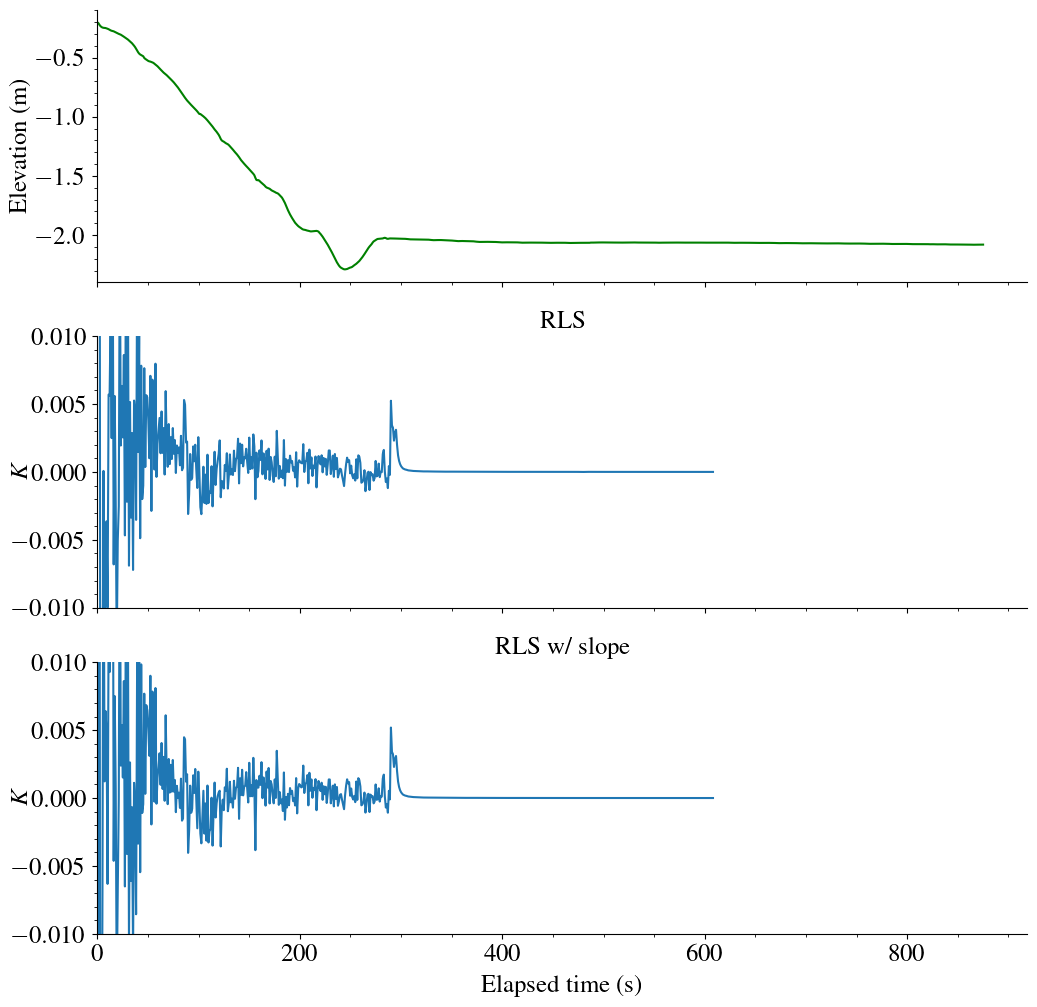

In [9]:
fig, axs = plt.subplots(figsize=(12, 12), nrows=3, sharex=True)

axs[0].plot(m2009_df.time_rel, m2009_df.pz, "g")
axs[0].set_ylabel("Elevation (m)")
axs[0].yaxis.set_label_coords(-0.07, 0.5)

axs[1].plot(p2014_df.time_rel, p2014_df.Km_sym)
axs[1].set_ylabel("$K$")
axs[1].yaxis.set_label_coords(-0.07, 0.5)
axs[1].set_ylim(bottom=-0.01, top=0.01)
axs[1].set_title("RLS")

axs[2].plot(p2022_df.time_rel, p2022_df.Km_sym)
axs[2].set_ylabel("$K$")
axs[2].yaxis.set_label_coords(-0.07, 0.5)
axs[2].set_ylim(bottom=-0.01, top=0.01)
axs[2].set_title("RLS w/ slope")

axs[2].set_xlabel("Elapsed time (s)")
axs[2].xaxis.set_label_coords(0.5, -0.15)
axs[2].set_xlim(left=0)

for idx, ax in enumerate(axs):
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

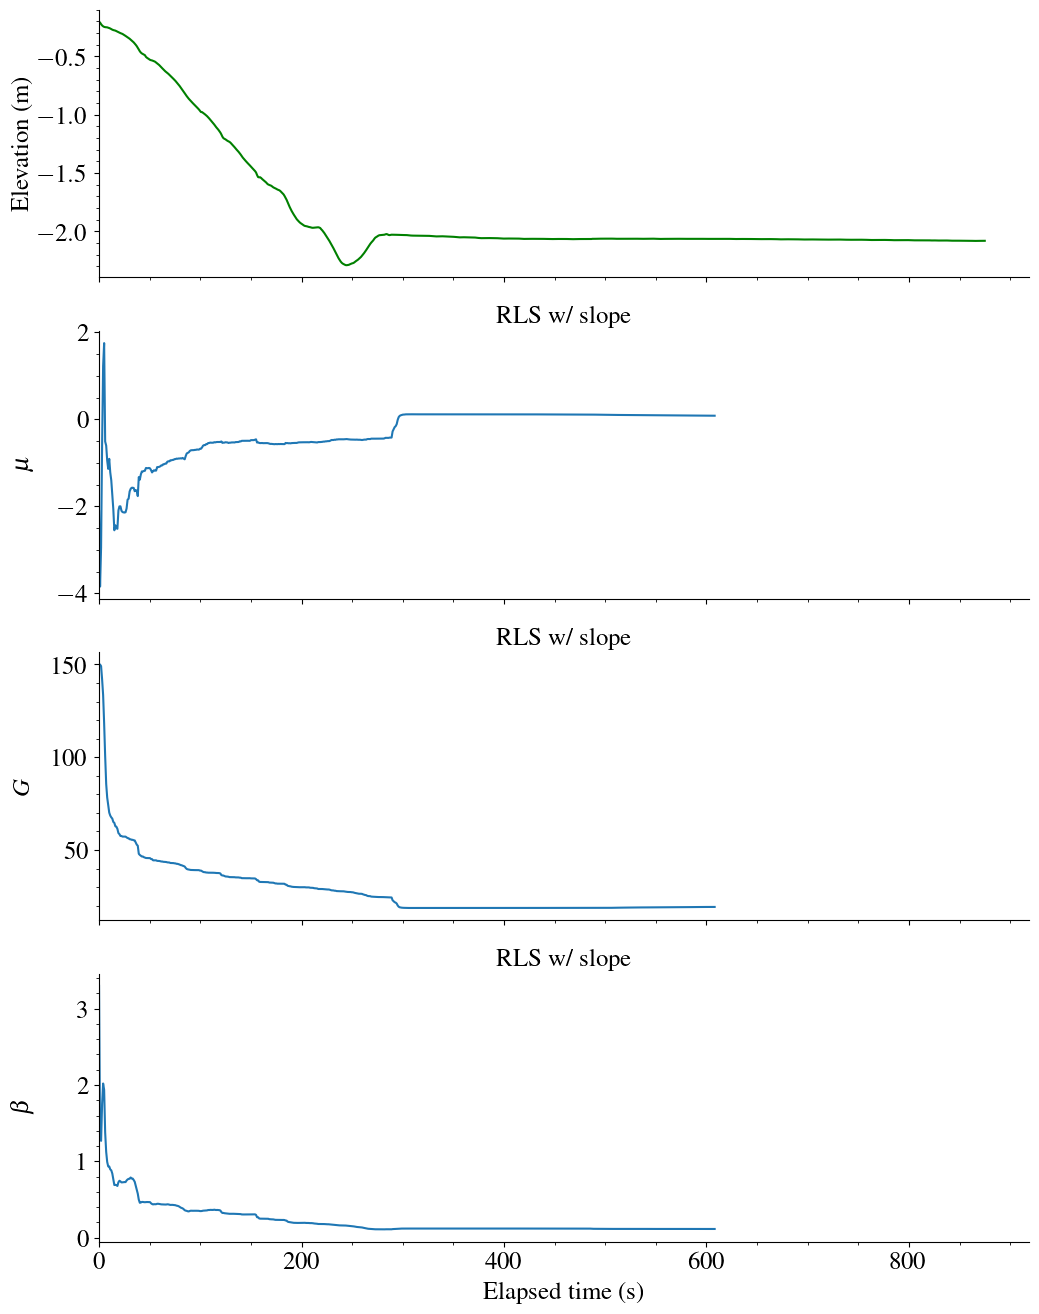

In [10]:
fig, axs = plt.subplots(figsize=(12, 16), nrows=4, sharex=True)

axs[0].plot(m2009_df.time_rel, m2009_df.pz, "g")
axs[0].set_ylabel("Elevation (m)")
axs[0].yaxis.set_label_coords(-0.07, 0.5)

axs[1].plot(p2022_df.time_rel, p2022_df.m_sym)
axs[1].set_ylabel("$\mu$")
axs[1].yaxis.set_label_coords(-0.07, 0.5)
# axs[1].set_ylim(bottom=-2.5, top=2.5)
axs[1].set_title("RLS w/ slope")

axs[2].plot(p2022_df.time_rel, p2022_df.G_sym)
axs[2].set_ylabel("$G$")
axs[2].yaxis.set_label_coords(-0.07, 0.5)
# axs[2].set_ylim(bottom=-2.5, top=2.5)
axs[2].set_title("RLS w/ slope")

axs[3].plot(p2022_df.time_rel, p2022_df.B_sym)
axs[3].set_ylabel("$\\beta$")
axs[3].yaxis.set_label_coords(-0.07, 0.5)
# axs[3].set_ylim(bottom=-2.5, top=2.5)
axs[3].set_title("RLS w/ slope")

axs[3].set_xlabel("Elapsed time (s)")
axs[3].xaxis.set_label_coords(0.5, -0.15)
axs[3].set_xlim(left=0)

for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())